In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

# Question 1

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [287]:
data = pd.read_csv('lalonde.csv', index_col=0)

data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [288]:
treated_group = data[data['treat'] == 1]
untreated_group = data[data['treat'] == 0]

In [289]:
'''
print('Treated group statistics:')
print(treated_group['re78'].describe())
print('\nMedian value for treated group:')
print(treated_group['re78'].median())

print('\n\nUntreated group statistics:')
print(untreated_group['re78'].describe())
print('\nMedian value for untreated group:')
print(untreated_group['re78'].median())
'''

treated_desc = treated_group['re78'].describe().rename("Treated")
treated_desc.set_value('median', treated_group['re78'].median())

untreated_desc = untreated_group['re78'].describe().rename("Unreated")
untreated_desc.set_value('median', untreated_group['re78'].median())

stats_df = pd.concat([treated_desc, untreated_desc], axis=1)
stats_df

,Treated,Unreated
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000
median,4232.309000,4975.505000


Some observations:
- The max earning value for the treated group is way higher than the max earning for the untreated group, but the mean and median values are higher for the untreated group, which leads us to think that the treated group overall didn't get better results, even though some outliers did get a very good outcome from the trainee program. We can also observe the higher standard deviation for the treated group, which goes in the same direction.

Now lets display some plots of the distribution to visually see what it looks like.

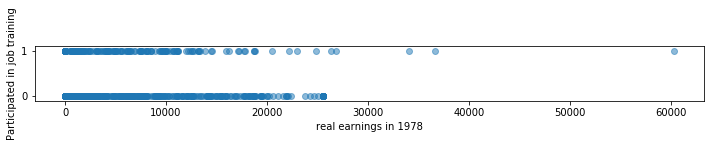

In [290]:
plt.figure(figsize=(12,1))
plt.scatter(data['re78'], data['treat'], alpha=0.5)
plt.xlabel('real earnings in 1978')
plt.ylabel('Participated in job training')

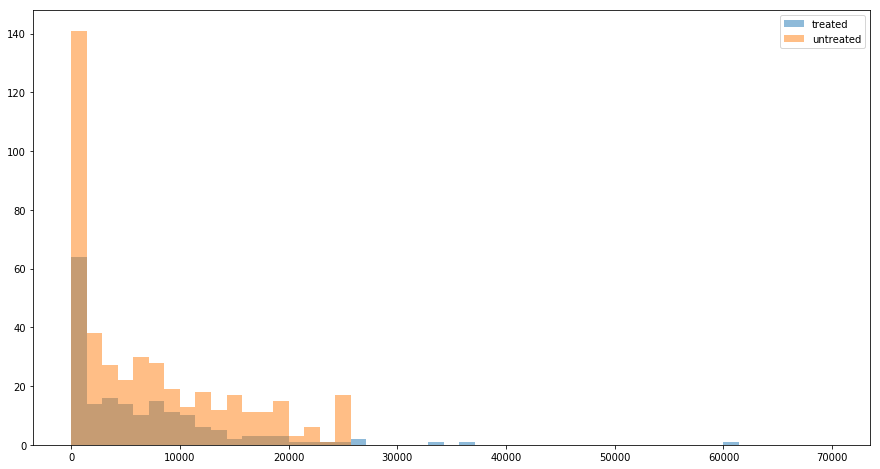

In [291]:
bins = np.linspace(0,70000, 50)

plt.figure(figsize=(15,8))
plt.hist(treated_group['re78'], bins, alpha=0.5, label='treated')
plt.hist(untreated_group['re78'], bins, alpha=0.5, label='untreated')
plt.legend(loc='upper right')
plt.show()

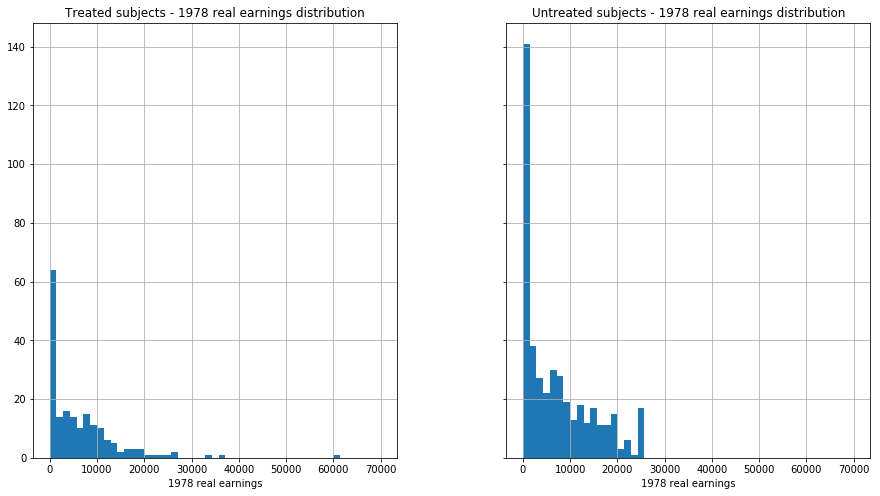

In [292]:
def set_axis():
    return


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8), sharex=True, sharey=True)
treated_group.hist('re78', bins=bins, label='treated', ax=ax1)
untreated_group.hist('re78', bins=bins, label='untreated', ax=ax2)

ax1.set_title('Treated subjects - 1978 real earnings distribution')
ax1.set_xlabel('1978 real earnings')
ax2.set_title('Untreated subjects - 1978 real earnings distribution')
ax2.set_xlabel('1978 real earnings')

#TODO create function and set all configs for axis etc. for both histograms

In [293]:
# TODO our naive conclusion

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [294]:
treated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [295]:
untreated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


Below, we compare the percent of true/false values for features concerning race ('black' and 'hispan'), marriage and degree for each group and compare in bar charts.

We also plot the distributions for the age, education and income prior to the experience to compare between the two groups.

These observations will let us determine if the two groups are equivalently distributed.

black percent for treated group: 84.32%
black percent for untreated group: 20.28%



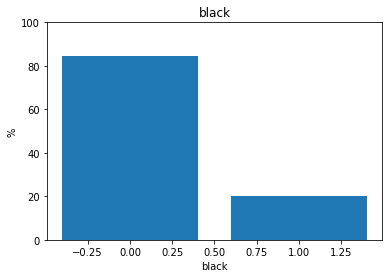

hispan percent for treated group: 5.95%
hispan percent for untreated group: 14.22%



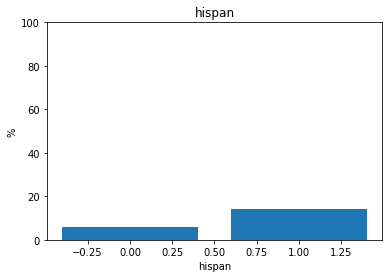

married percent for treated group: 18.92%
married percent for untreated group: 51.28%



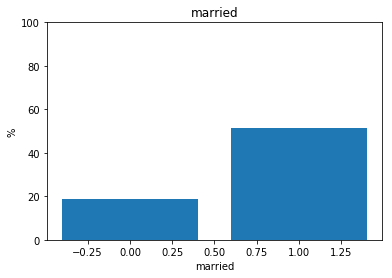

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 59.67%



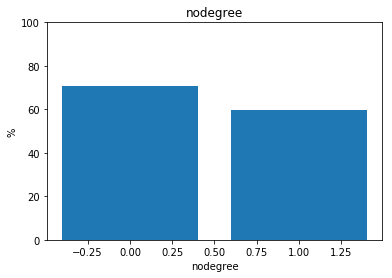

[None, None, None, None]

In [325]:
def percentage_comparison(feature):
    treated_percent = 100 * np.sum(treated_group[feature]) / treated_group[feature].size
    untreated_percent = 100 * np.sum(untreated_group[feature]) / untreated_group[feature].size
    print('{} percent for treated group: {:0.2f}%'.format(feature, treated_percent))
    print('{} percent for untreated group: {:0.2f}%'.format(feature, untreated_percent))
    print()
    
    x = [u'True', u'False']
    y = [treated_percent, untreated_percent]
    fig, ax = plt.subplots() 
    plt.bar([0,1], [treated_percent, untreated_percent])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('%')
    
    ax.set_ylim([0,100])
    
    plt.show()

features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(f) for f in features_to_compare]

# TODO plot values above in small bar charts with yaxis 100% to compare visually
# TODO plot in subplots side by side, nicer
# Display bar value in each bar
# TODO plot age distribution, plot years of education, display income before exp
# TODO box plots?
# TODO new column with 'race_other' (if black and hispan == 0)

- Proportionally, the number of blacks in the control group is way higher than in the treated group.
- There is also a disreptancy in the percentage of married people in each group


These observations show that the treatment assignment isn't random and there is a huge bias between the two groups in some of the covariates, such as the number of blacks. This doesn't correspond to a randomized experiment. Such disruptancies cause major differences in the groups, which alone is enough to invalidate the naive conclusions made in part 1, or at least put the above findings into question.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [326]:
logistic = LogisticRegression()

confounders = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

y = data['treat']
X = data[confounders]
logistic.fit(X, y)

prop_score = [e for (_,e) in logistic.predict_proba(X)]

prop_score[:10]

[0.44335042297442523,
 0.14465953267416379,
 0.72235463271079448,
 0.66415051691188443,
 0.69828561085601226,
 0.70011831106776024,
 0.7317915010581123,
 0.65653137087874036,
 0.67840163069314863,
 0.076562002083422551]

Which means, for example, that the second person in the above array has a 14.5% chance of being in the treated group.


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [298]:
# TODO

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [299]:
# TODO

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [300]:
# TODO

## Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


#### 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [301]:
#TODO

#### 2. 
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [302]:
# TODO